# Tugas Kecil Intelegensi Buatan: Exploratory Data Analysis

## Import Libraries

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Constants

In [161]:
from matplotlib.colors import LinearSegmentedColormap

TARGET = "price_range"
RANDOM_STATE = 42

THEME = 'orangered'
CMAP_COLOUR = LinearSegmentedColormap.from_list(THEME, ['#FFECEC',THEME])

## Import Dataset

In [162]:
train_set = pd.read_csv("../data/data_train.csv")
train_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0


In [163]:
val_set = pd.read_csv("../data/data_validation.csv")
val_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3


# Why do we need to split the data into training and validation sets?

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. Later on, we will also implement cross validation to further evaluate our model.

# Preprocessing

The following are the steps taken to preprocess the data before feeding it into a classifier:

1. Feature Engineering
2. Feature Dropping
3. Encoding Categorical Columns
4. Resampling

The preprocessing is done with a pipeline approach by designing dedicated classes and/or functions for each steps and automating it by feeding the data to a predefined pipeline.

## Feature Creation

This step includes creating and combining features that may improve the performance of the classifier.

In [164]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create class to create new features
class FeatureCreator(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        self.fitted_cols = X.columns
        return self
    
    def transform(self, X):
       
        # Get the newly created columns
        new_columns = list(filter(lambda x: x not in self.fitted_cols, X.columns))

        # Compute correlation with TARGET feature for the newly created columns
        if TARGET in X.columns:
            target_corr = X[new_columns].apply(lambda col: col.corr(X[TARGET]))

            # Print correlation results for the newly created columns
            for col, corr in target_corr.items():
                print(f"Feature {col} created with {corr} correlation to target")
            
        print()
        
        return X

## Feature Dropping

This step is to remove null and previously combined columns from the dataset.

In [165]:
# Create feature dropper class
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X

## Feature Scaling

In [166]:
def get_non_binary_numeric_features(data):
    # Get the data types of all columns
    column_data_types = data.dtypes

    # Find columns with numeric data types
    numeric_columns = column_data_types[column_data_types.apply(lambda x: pd.api.types.is_numeric_dtype(x))].index

    # Filter out binary features (those with only 2 unique values)
    non_binary_numeric_features = []
    for col in numeric_columns:
        if col == TARGET:
            continue
        
        unique_values = data[col].nunique()
        if unique_values > 2:
            non_binary_numeric_features.append(col)

    return non_binary_numeric_features

In [167]:
from sklearn.preprocessing import StandardScaler

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = None
        self.numerical_cols = None
    
    def fit(self, X, y=None):
        self.numerical_cols = get_non_binary_numeric_features(X)

        self.scaler = StandardScaler().fit(X[self.numerical_cols])
        return self
    
    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        
        return X_scaled

## Encode Categorical Features

This step is to encode categorical columns into binary columns or specific labels.

In [168]:
# Create custom encoder class
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        
        cat_cols = X.select_dtypes(include=['object'])
        
        for col in cat_cols:
            
            # Perform one-hot encoding
            X_encoded = pd.concat([X_encoded, pd.get_dummies(X_encoded[col], prefix=col)], axis=1)

            # Drop original categorical columns from DataFrame
            X_encoded.drop(col, axis=1, inplace=True)
        
        return X_encoded

# Prepare Training and Validation set

All of the preprocessing steps will be compiled in this section.

## Fitting the Pipeline

We will pass down the training and validation set through a pipeline that performs the preprocessing steps defined before.

In [169]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("featurecreator", FeatureCreator()),
                     ("dropper", FeatureDropper()),
                    ("scaler", FeatureScaler())])

In [170]:
train_set = pipeline.fit_transform(train_set)
val_set = pipeline.transform(val_set)

In [171]:
train_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-1.007554,1,-0.886156,1,1.787108,1,0.497776,1.359548,-1.423519,-1.527598,...,0.148091,-1.011397,-0.073965,-0.305926,-0.152151,-0.007808,1,0,0,1
1,-0.453935,0,0.832833,0,2.481131,1,-1.154527,0.319457,-0.010617,0.227541,...,-1.294075,-0.545012,0.667248,1.359671,-1.296139,-1.675363,1,0,0,2
2,0.567237,1,0.587263,1,-0.988982,0,0.167315,-0.027240,-0.971390,-0.650028,...,-0.886849,-1.701648,0.490062,1.121729,2.364625,-1.304796,1,0,1,2
3,-0.309715,0,0.218908,0,-0.757641,1,1.544234,-0.373938,1.684865,-1.088813,...,0.022099,0.376100,-0.814251,-1.495639,-1.296139,-1.490080,1,1,1,0
4,-1.361126,0,-1.254511,1,-0.757641,0,1.434080,0.319457,0.074157,-0.650028,...,-0.403127,-1.097679,-1.430228,1.359671,1.449434,-0.378376,0,0,1,0


In [172]:
print(len(train_set))

1400


In [173]:
val_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-0.919161,0,0.832833,0,-0.757641,0,-1.374834,0.319457,1.374027,-1.088813,...,-1.402069,-1.155977,0.410282,-0.781811,0.305445,1.474463,0,0,1,1
1,-1.568152,1,-1.254511,1,-0.526301,1,0.497776,1.359548,0.158931,0.227541,...,1.394519,1.082674,0.460377,-0.305926,-0.838544,-0.378376,1,1,0,2
2,-1.088969,1,1.692327,1,-0.988982,0,-1.264680,-1.414029,1.204479,0.227541,...,-0.889099,-0.880809,1.706246,-1.733581,-0.838544,-0.748944,0,0,0,3
3,-1.075012,0,-0.640586,0,-0.294960,0,0.773160,0.666154,0.554544,-1.088813,...,0.492321,1.427800,-1.427445,1.121729,2.135827,-0.007808,1,1,1,0
4,-1.493716,0,-0.763371,1,0.630404,1,-0.493606,-1.414029,-0.519262,-0.650028,...,-0.454874,-1.030053,1.526277,-0.543869,-0.838544,1.289179,1,1,0,3


In [174]:
print(len(val_set))

600


In [175]:
null_test = val_set.columns[val_set.isnull().any()]
print(val_set[null_test].isnull().sum())

Series([], dtype: float64)


## Matching the Train and Validation Columns

Columns need to be matched between the train and validation set as there may be columns that exists in the validation set but not in the training set, and vice versa.

In [176]:
def match_columns(train, test):
    # Get list of columns in training set
    train_cols = train.columns.tolist()
    
    # Get list of columns in test set
    test_cols = test.columns.tolist()
    
    # Remove any columns in test set that aren't in training set
    for col in test_cols:
        if col not in train_cols:
            test = test.drop(col, axis=1)
    
    # Add any missing columns to test set and fill with 0
    for col in train_cols:
        if col not in test_cols:
            test[col] = 0
    
    # Reorder columns in test set to match training set
    test = test[train_cols]
    
    # Return modified test set
    return test

In [177]:
# Match the columns
val_set = match_columns(train_set, val_set)

In [178]:
train_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-1.007554,1,-0.886156,1,1.787108,1,0.497776,1.359548,-1.423519,-1.527598,...,0.148091,-1.011397,-0.073965,-0.305926,-0.152151,-0.007808,1,0,0,1
1,-0.453935,0,0.832833,0,2.481131,1,-1.154527,0.319457,-0.010617,0.227541,...,-1.294075,-0.545012,0.667248,1.359671,-1.296139,-1.675363,1,0,0,2
2,0.567237,1,0.587263,1,-0.988982,0,0.167315,-0.027240,-0.971390,-0.650028,...,-0.886849,-1.701648,0.490062,1.121729,2.364625,-1.304796,1,0,1,2
3,-0.309715,0,0.218908,0,-0.757641,1,1.544234,-0.373938,1.684865,-1.088813,...,0.022099,0.376100,-0.814251,-1.495639,-1.296139,-1.490080,1,1,1,0
4,-1.361126,0,-1.254511,1,-0.757641,0,1.434080,0.319457,0.074157,-0.650028,...,-0.403127,-1.097679,-1.430228,1.359671,1.449434,-0.378376,0,0,1,0


In [179]:
val_set.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,-0.919161,0,0.832833,0,-0.757641,0,-1.374834,0.319457,1.374027,-1.088813,...,-1.402069,-1.155977,0.410282,-0.781811,0.305445,1.474463,0,0,1,1
1,-1.568152,1,-1.254511,1,-0.526301,1,0.497776,1.359548,0.158931,0.227541,...,1.394519,1.082674,0.460377,-0.305926,-0.838544,-0.378376,1,1,0,2
2,-1.088969,1,1.692327,1,-0.988982,0,-1.264680,-1.414029,1.204479,0.227541,...,-0.889099,-0.880809,1.706246,-1.733581,-0.838544,-0.748944,0,0,0,3
3,-1.075012,0,-0.640586,0,-0.294960,0,0.773160,0.666154,0.554544,-1.088813,...,0.492321,1.427800,-1.427445,1.121729,2.135827,-0.007808,1,1,1,0
4,-1.493716,0,-0.763371,1,0.630404,1,-0.493606,-1.414029,-0.519262,-0.650028,...,-0.454874,-1.030053,1.526277,-0.543869,-0.838544,1.289179,1,1,0,3


Below, we examine each column's correlation to the target variable after preprocessing.

In [180]:
train_set.corr()[TARGET].sort_values(ascending=False)

price_range      1.000000
ram              0.918319
battery_power    0.184801
px_width         0.178713
px_height        0.158833
blue             0.041947
wifi             0.034329
three_g          0.027098
int_memory       0.026176
sc_w             0.019912
clock_speed      0.014031
sc_h             0.012149
talk_time        0.011113
m_dep            0.001205
four_g           0.000551
n_cores         -0.000582
fc              -0.003842
pc              -0.005214
dual_sim        -0.010756
touch_screen    -0.029842
mobile_wt       -0.074769
Name: price_range, dtype: float64

# Implement Classifiers


In this section, we will implement classifiers to train on.

In [181]:
from Models.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # TODO: Change this to the Naive Bayes from scratch

knn = KNeighborsClassifier()
nb = GaussianNB()

clfs = [knn, nb]

In [182]:
# Split predictor and target variable
X_train = train_set.drop([TARGET], axis=1)
y_train = train_set[TARGET]

X_val = val_set.drop([TARGET], axis=1)
y_val = val_set[TARGET]

In [183]:
for clf in clfs:
    clf.fit(X_train, y_train)

# Evaluation

In this section, we will evaluate the performance of our classifier on the training and validation set.

In [184]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Macro Precision','Macro Recall','Macro F1-score'],
                          columns = [model_name])
    
    result = (result * 100).round(5).astype(str) + '%'                            
    return result

In [185]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name=None):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    
    if model_name is None:
        model_name = clf.__class__.__name__
    
    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print()
    print(f"\n\t  {model_name} EVALUATION REPORT")
    print("="*55)
    print("\n\t\t  Training Set Performance")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t\t  Validation Set Performance")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
    
    # Create figure and subplots 
    fig, ax1 = plt.subplots(1, 1, dpi=90, figsize=(12, 5))
    
    # Report desired results as a summary in the form of a table
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax1.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 4.2)
    table.set_fontsize(12)
    ax1.axis('tight')
    # Hide the axes
    ax1.axis('off')
    # set the title
    ax1.set_title('{} Performance Summary'.format(model_name), fontsize=18)
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color(THEME)
              
    plt.tight_layout()
    plt.show()



	  KNeighborsClassifier EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       358
           1       0.64      0.67      0.66       356
           2       0.70      0.70      0.70       345
           3       0.89      0.74      0.81       341

    accuracy                           0.75      1400
   macro avg       0.76      0.75      0.75      1400
weighted avg       0.75      0.75      0.75      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.80      0.74       142
           1       0.47      0.47      0.47       144
           2       0.50      0.51      0.50       155
           3       0.84      0.71      0.77       159

    accuracy                           0.62       600
   macro avg       0.

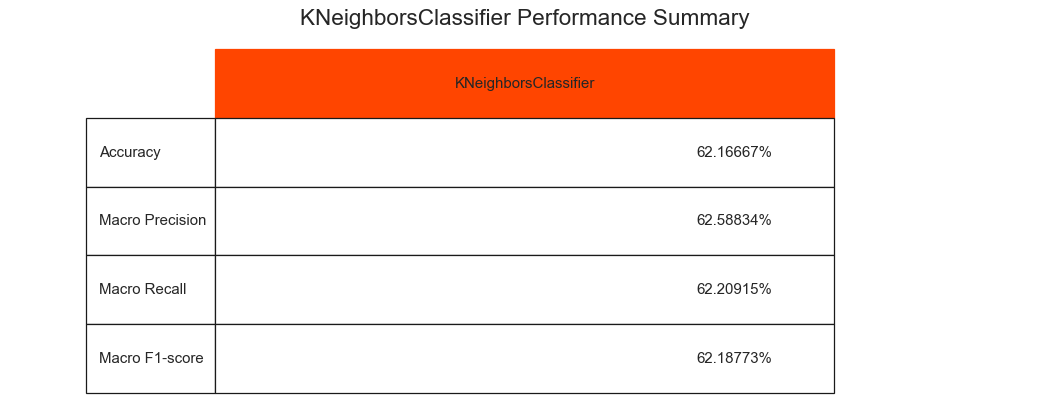



	  GaussianNB EVALUATION REPORT

		  Training Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       358
           1       0.75      0.75      0.75       356
           2       0.72      0.72      0.72       345
           3       0.90      0.89      0.89       341

    accuracy                           0.82      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.82      0.82      1400


		  Validation Set Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       142
           1       0.66      0.65      0.65       144
           2       0.68      0.71      0.70       155
           3       0.90      0.89      0.90       159

    accuracy                           0.78       600
   macro avg       0.78      0.

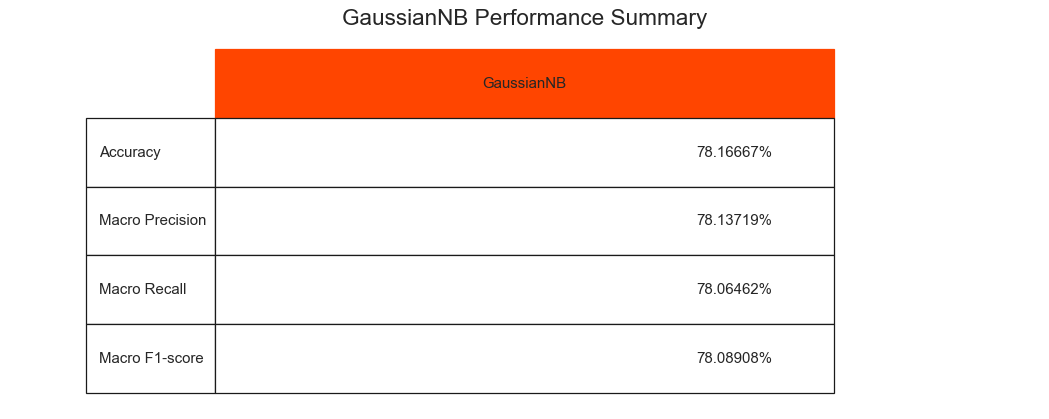

In [186]:
for clf in clfs:
    model_evaluation(clf, X_train, X_val, y_train, y_val)